In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


import warnings
warnings.filterwarnings('ignore')

In [24]:
data = pd.read_csv('data_banknote_authentication.txt',sep=',') # Load the data
data.dropna() # Drop observations with NA cells
data = shuffle(data) # Shuffle the data
data.reset_index(inplace=True, drop=True) # Reset df indices

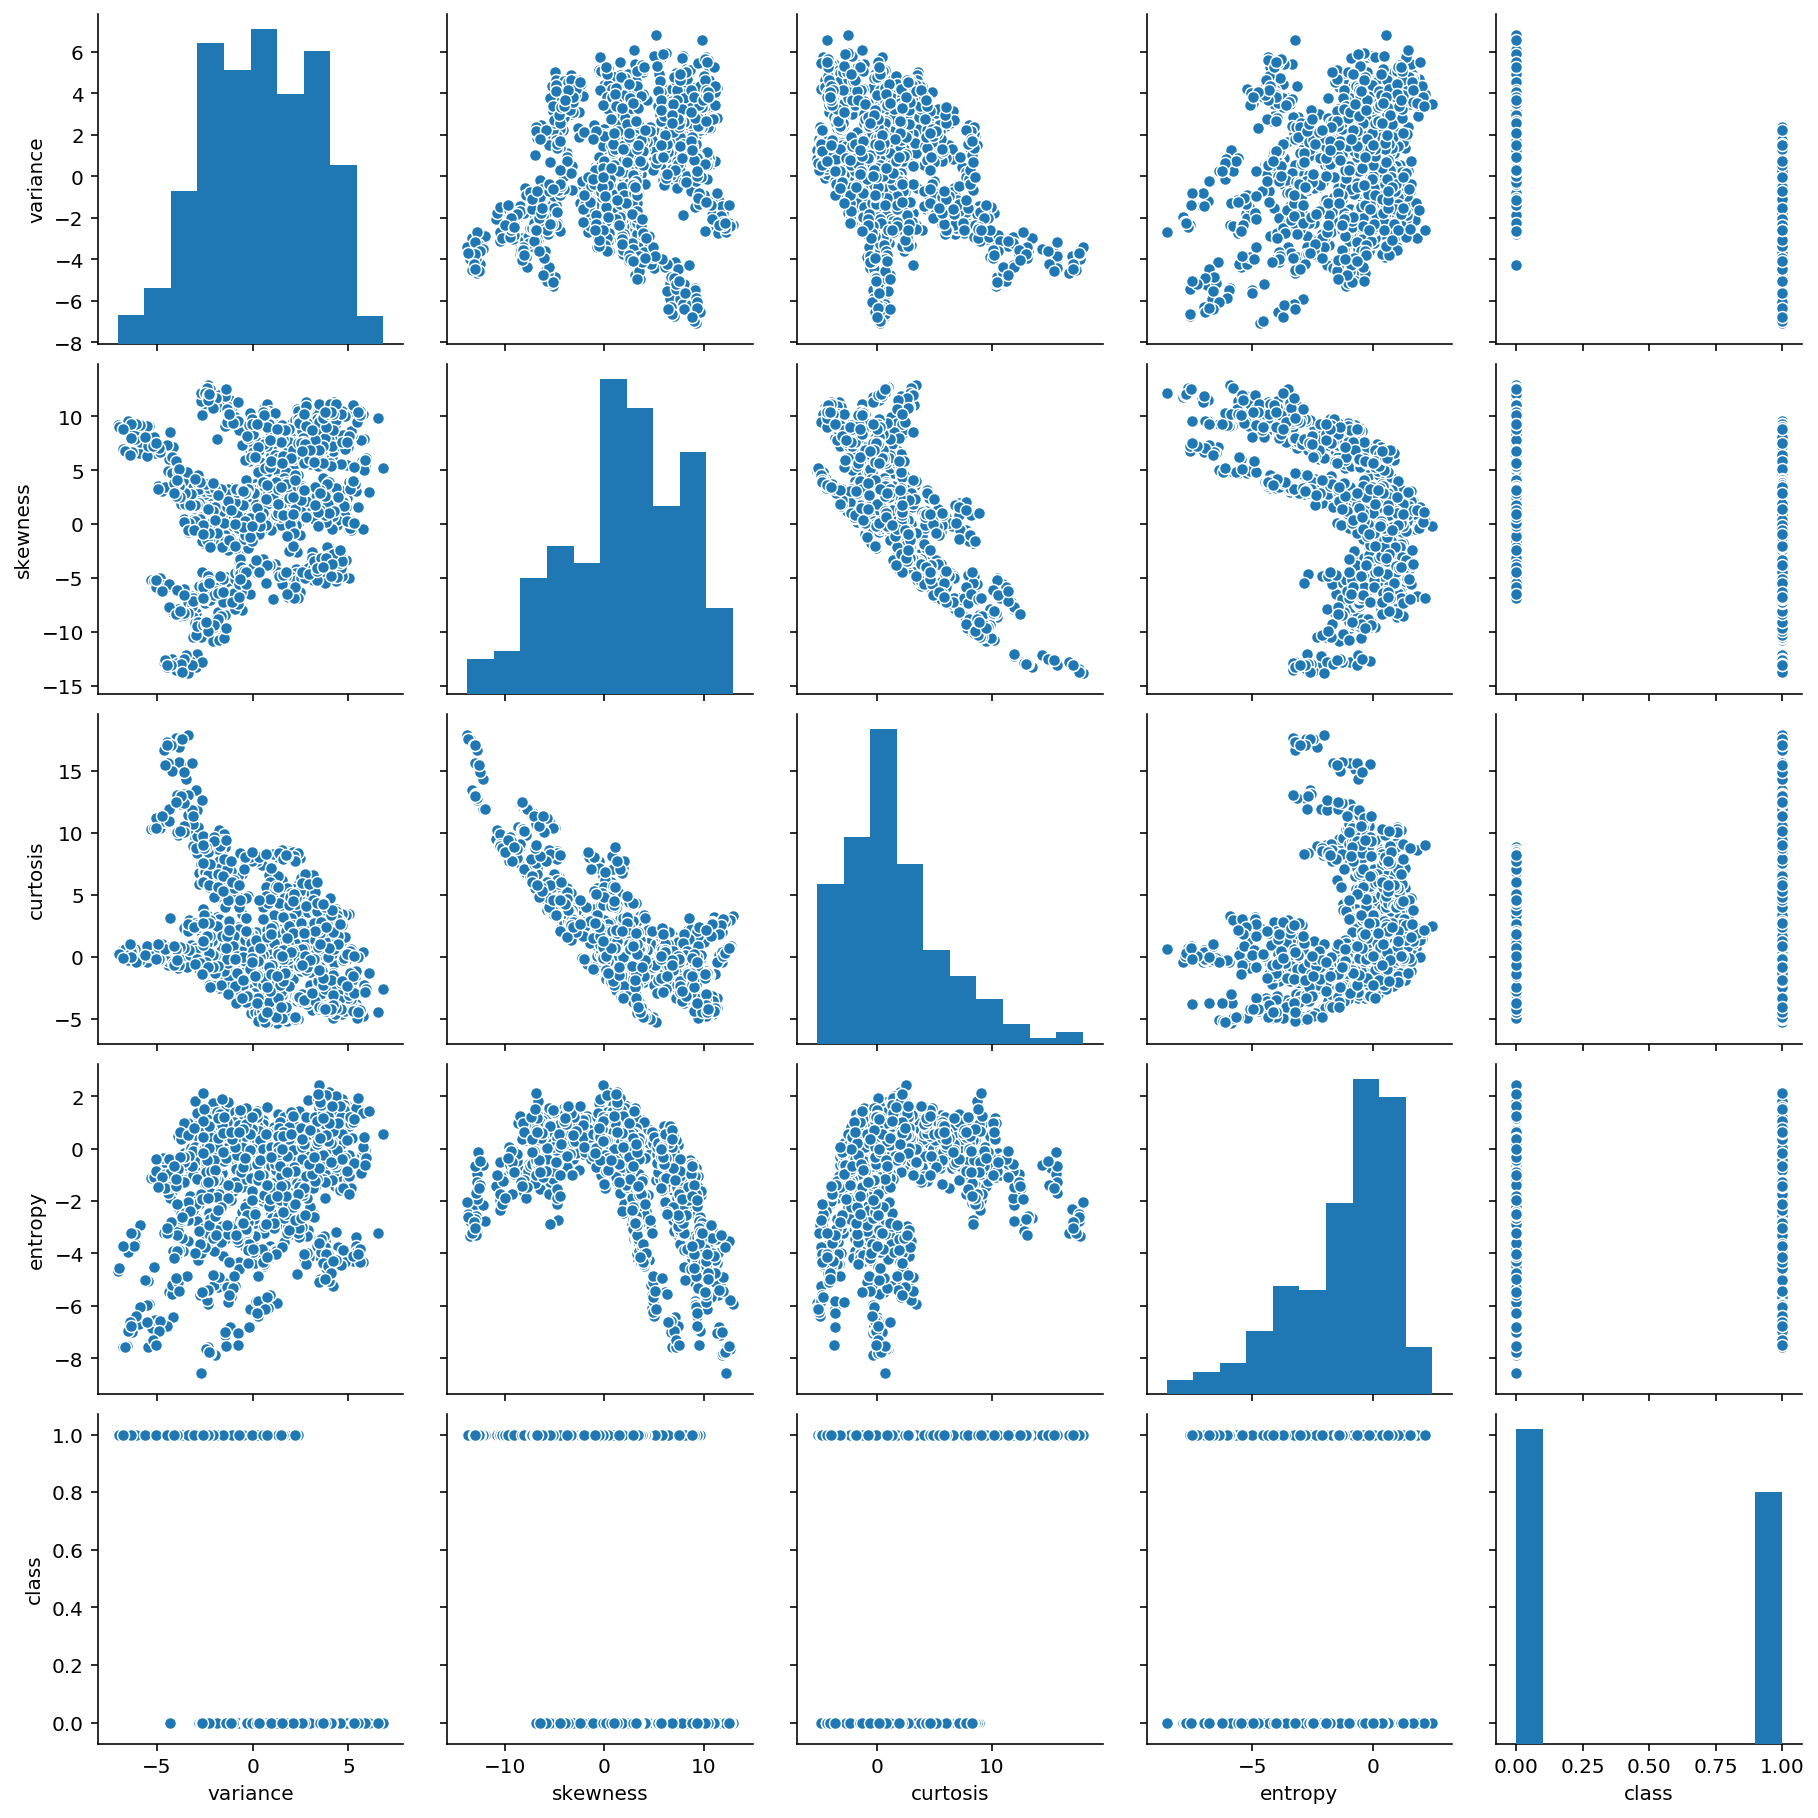

In [25]:
g = sns.pairplot(data) # Check if there is obvious correlation between features.

In [26]:
X = data[['variance','skewness','curtosis','entropy']].values # Split data feature and class
y = data[['class']].values
X = preprocessing.minmax_scale(X,[0.2,0.8]) # Scale the data in [0.2,0.8]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=3) # 85-15 split


y_trainCategorical = to_categorical(y_train) # There are two categories. One hot encode the categories.
y_testCategorical = to_categorical(y_test)

In [27]:
kf = StratifiedKFold(n_splits=5) # Will use 5 fold to train the network. We need to use Stratified K-fold to preserve
# kf = KFold(n_splits=5)                        # class imbalance

In [43]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience = 10, cooldown=0), # Change learning rate in case there is a plateau
            EarlyStopping(monitor='val_acc', min_delta=1e-5, patience = 10)] # Early stopping parameters

In [46]:
ada = keras.optimizers.Adadelta(lr=10.0)

In [47]:
scoresVector = []
for train_index, test_index in kf.split(X_train,y_train):
    model = Sequential()
    model.add(Dense(10, activation = 'sigmoid', input_dim = 4)) # Hidden layers have 10 neurons
    model.add(Dense(10, activation = 'sigmoid'))
    model.add(Dropout(0.25)) # Dropout out is set to 25%
    model.add(Dense(2, activation = 'sigmoid')) # There are two classes.
    model.compile(loss = 'binary_crossentropy',optimizer = ada, metrics=['accuracy'])
    XFoldTrain = X_train[train_index]
    yFoldTrain = y_trainCategorical[train_index]
    XFoldTest = X_train[test_index]
    yFoldTest = y_trainCategorical[test_index]
    
    history = model.fit(XFoldTrain, yFoldTrain, 
                  epochs = 50, 
                  validation_data = (XFoldTest,yFoldTest),
                  callbacks = callbacks,verbose = 0);
    
    scores = model.evaluate(XFoldTest, yFoldTest, verbose=0)
    accuracyKFold = model.metrics_names[1]
    print(f"{accuracyKFold}: {scores[1]*100}")
    scoresVector.append(scores[1] * 100)
print(f"The average accuracy is: {np.mean(scoresVector)} (+/- {np.std(scoresVector)})")

acc: 97.97570859855004
acc: 99.19028340080972
acc: 96.35627530364373
acc: 95.95141710057432
acc: 96.74796733429761
The average accuracy is: 97.24433034757507 (+/- 1.1856044954085039)


In [41]:
testAccuracy = model.evaluate(X_test, y_testCategorical,verbose = 0)[1]
print(f"The test set accuracy is {testAccuracy}")

The test set accuracy is 0.9710144927536232


In [40]:
model.save("modelBanknote.h5") # Save the model.

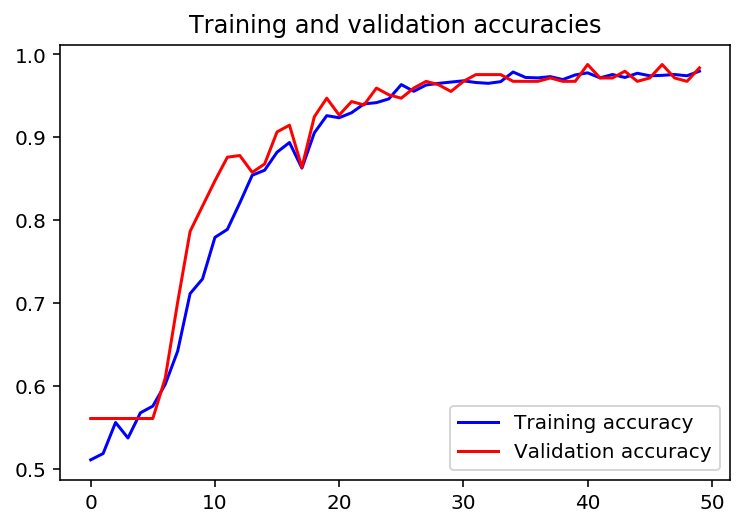

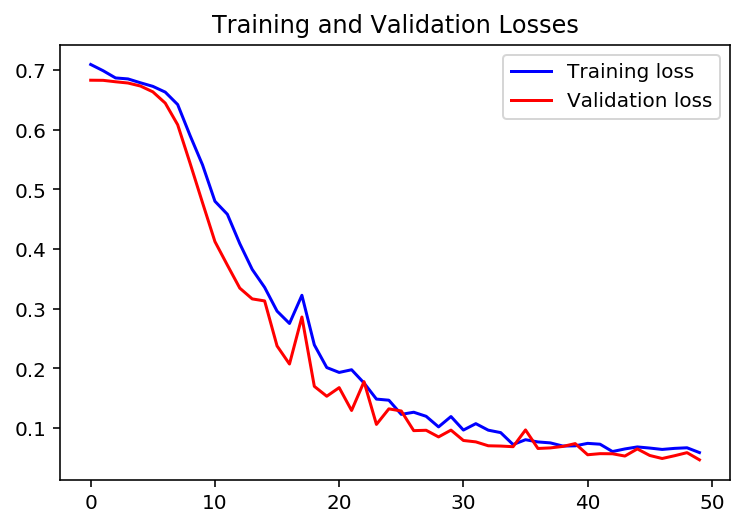

In [42]:
acc = history.history['acc']
validationAcc = history.history['val_acc']
trainingLoss = history.history['loss']
validationLoss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, validationAcc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracies')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, trainingLoss, 'b', label='Training loss')
plt.plot(epochs, validationLoss, 'r', label='Validation loss')
plt.title('Training and Validation Losses')
plt.legend()
 
plt.show()